# Notebook that generates my README

In [1]:
import math
import os
from collections import Counter, defaultdict
from datetime import datetime
from functools import lru_cache
from operator import attrgetter

import jinja2
import matplotlib.pyplot as plt
from github import Github
from tqdm import tqdm

token_path = ".TOKEN"
if os.path.exists(token_path):
    with open(token_path) as f:
        token = f.read().strip()
else:
    token = os.environ["TOKEN"]

g = Github(token)
projects = ["basnijholt", "python-adaptive", "topocm", "python-kasa", "kwant-project"]
repos = []
for project in projects:
    repos.extend(list(g.get_user(project).get_repos()))


@lru_cache(maxsize=None)
def get_n_commits(full_repo_name, user="basnijholt"):
    repo = get_repo(full_repo_name)
    try:
        return next(
            s.total for s in repo.get_stats_contributors() if s.author.login == user
        )
    except StopIteration:
        return float("nan")
    except TypeError:
        return 0


@lru_cache(maxsize=None)
def get_repo(full_repo_name):
    return g.get_repo(full_repo_name)


@lru_cache(maxsize=None)
def get_stargazers_with_dates(full_repo_name):
    return list(get_repo(full_repo_name).get_stargazers_with_dates())


@lru_cache(maxsize=None)
def get_commits(full_repo_name, author="basnijholt"):
    repo = get_repo(full_repo_name)
    return list(repo.get_commits(author=author))


def split(x, at_index=5):
    return x[:at_index], x[at_index:]

## Number of stars ⭐️

In [2]:
mapping = defaultdict(list)
for repo in repos:
    namespace, name = repo.full_name.split("/", 1)
    mapping[namespace].append(repo)

most_stars = sorted(
    (repo for project in projects for repo in mapping[project]),
    key=attrgetter("stargazers_count"),
    reverse=True,
)

most_stars_strs = [
    f"{i+1}. [{repo.full_name}](https://github.com/{repo.full_name}/), {repo.stargazers_count} ⭐️s"
    for i, repo in enumerate(most_stars[:20])
]

most_stars_strs_summary, most_stars_strs_rest = split(most_stars_strs, 5)

## Number of commits 

In [3]:
most_committed = []
for repo in tqdm(repos):
    full_name = repo.full_name if not repo.fork else repo.source.full_name
    if full_name == "regro/cf-graph-countyfair":
        # https://github.com/PyGithub/PyGithub/issues/1599
        continue
    n_commits = get_n_commits(full_name)
    if not math.isnan(n_commits):
        most_committed.append((full_name, n_commits))

most_committed = sorted(set(most_committed), key=lambda x: x[1], reverse=True)

most_committed_strs = [
    f"{i+1}. [{full_name}](https://github.com/{full_name}/), {n_commits} commits :octocat:"
    for i, (full_name, n_commits) in enumerate(most_committed[:20])
]

most_committed_strs_summary, most_committed_strs_rest = split(most_committed_strs, 5)

100%|██████████| 289/289 [04:16<00:00,  1.13it/s]


In [4]:
stargazers = []
for repo in tqdm(most_stars[:20]):
    stargazers.extend(get_stargazers_with_dates(repo.full_name))

stargazers = sorted(stargazers, key=lambda sg: sg.starred_at)

dts = [sg.starred_at for sg in stargazers]
n_stars = list(range(1, len(dts) + 1))

100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


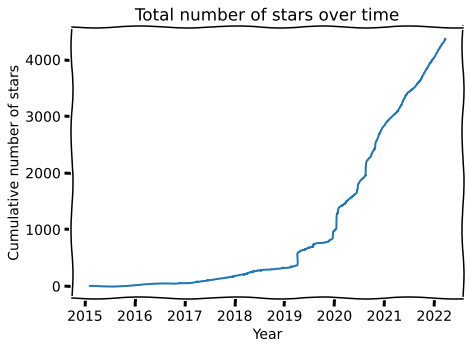

In [5]:
plt.xkcd()
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(dts, n_stars)
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative number of stars")
ax.set_title("Total number of stars over time")
plt.savefig("stars_over_time.png")

## Commit stats

In [6]:
all_commits = [get_commits(full_name) for full_name, _ in tqdm(most_committed[:30])]
all_commits = sum(all_commits, [])
all_commit_dates = [c.commit.author.date for c in all_commits]

100%|██████████| 30/30 [00:59<00:00,  1.99s/it]


In [7]:
weekdays = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
day_hist = [
    (weekdays[i], n)
    for i, n in sorted(Counter([d.weekday() for d in all_commit_dates]).items())
]

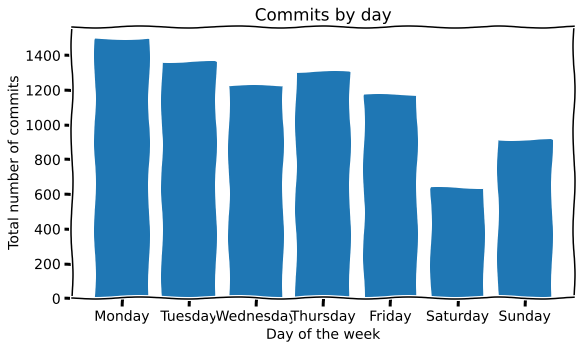

In [8]:
plt.xkcd()
fig, ax = plt.subplots(figsize=(9, 5))
ax.bar(*zip(*day_hist))
ax.set_xlabel("Day of the week")
ax.set_ylabel("Total number of commits")
ax.set_title("Commits by day")
plt.savefig("commits_per_weekday.png")

In [9]:
hour_hist = [
    (f"{i:02d}", n)
    for i, n in sorted(Counter([d.hour for d in all_commit_dates]).items())
]

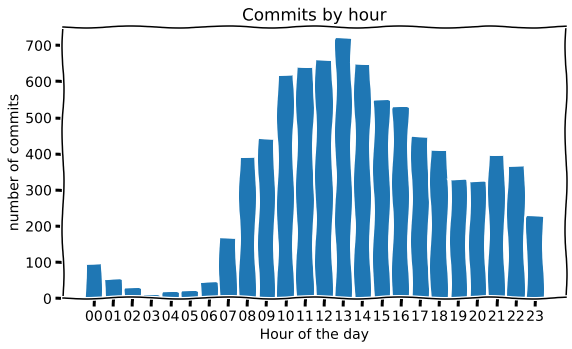

In [10]:
plt.xkcd()
fig, ax = plt.subplots(figsize=(9, 5))
ax.bar(*zip(*hour_hist))
ax.set_xlabel("Hour of the day")
ax.set_ylabel("number of commits")
ax.set_title("Commits by hour")
plt.savefig("commits_per_hour.png")

## Render template

In [11]:
template = """### Welcome to my profile 👋

<center>
  <table>
    <tr>
        <td><img width="300px" align="left" src="https://github-readme-stats.vercel.app/api/top-langs/?username=basnijholt&hide=TeX,Jupyter%20Notebook&layout=compact&theme=radical" /></td>
        <td><img align='right' src="https://github-readme-stats.vercel.app/api?username=basnijholt&show_icons=true&theme=radical" width="380"></td>
    </tr>
  </table>
</center>

![visitors](https://visitor-badge.glitch.me/badge?page_id=basnijholt.visitor-badge)

I am Bas. Here I present some (automatically generated) statistics about my activity on GitHub. For more info check out my website [www.nijho.lt](http://nijho.lt/).

![](https://www.nijho.lt/authors/admin/avatar_hu9e60e4b9bc120dfb6a666009f2878da6_182107_250x250_fill_q90_lanczos_center.jpg)

- 💬 Ask me about Python, home-automation, landscape photography, and quantum physics
- 📫 How to reach me: bas@nijho.lt

Last updated at {{ now }}.

# GitHub statistics — my top 20

## number of GitHub stars ⭐️

{{ "\n".join(most_stars_strs_summary) }}
<details><summary>Click to expand!</summary>

{{ "\n".join(most_stars_strs_rest) }}

</details>

![](https://github.com/basnijholt/basnijholt/raw/master/stars_over_time.png)

## number of commits :octocat:

{{ "\n".join(most_committed_strs_summary) }}
<details><summary>Click to expand!</summary>

{{ "\n".join(most_committed_strs_rest) }}

</details>

![](https://github.com/basnijholt/basnijholt/raw/master/commits_per_hour.png)

![](https://github.com/basnijholt/basnijholt/raw/master/commits_per_weekday.png)


"""
txt = jinja2.Template(template).render(
    most_stars_strs_summary=most_stars_strs_summary,
    most_stars_strs_rest=most_stars_strs_rest,
    most_committed_strs_summary=most_committed_strs_summary,
    most_committed_strs_rest=most_committed_strs_rest,
    now=str(datetime.now()),
)
with open("README.md", "w") as f:
    f.write(txt)
print(txt)

### Welcome to my profile 👋

<center>
  <table>
    <tr>
        <td><img width="300px" align="left" src="https://github-readme-stats.vercel.app/api/top-langs/?username=basnijholt&hide=TeX,Jupyter%20Notebook&layout=compact&theme=radical" /></td>
        <td><img align='right' src="https://github-readme-stats.vercel.app/api?username=basnijholt&show_icons=true&theme=radical" width="380"></td>
    </tr>
  </table>
</center>

![visitors](https://visitor-badge.glitch.me/badge?page_id=basnijholt.visitor-badge)

I am Bas. Here I present some (automatically generated) statistics about my activity on GitHub. For more info check out my website [www.nijho.lt](http://nijho.lt/).

![](https://www.nijho.lt/authors/admin/avatar_hu9e60e4b9bc120dfb6a666009f2878da6_182107_250x250_fill_q90_lanczos_center.jpg)

- 💬 Ask me about Python, home-automation, landscape photography, and quantum physics
- 📫 How to reach me: bas@nijho.lt

Last updated at 2022-03-21 12:11:54.116276.

# GitHub statistics — my top 20
